In [2]:
%load_ext autoreload
%autoreload 2

# Notebook: Models

In [3]:
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set()

## Load the dataset

In [4]:
from ceruleo.dataset.catalog.CMAPSS import CMAPSSDataset

2022-08-10 09:09:53.082266: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-10 09:09:53.115130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-10 09:09:53.115145: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
train_dataset = CMAPSSDataset(train=True, models='FD001')

test_dataset = CMAPSSDataset(train=False, models='FD001')[0:15]

### Create a transformer for a dataset

In [6]:
from ceruleo.dataset.analysis.numerical_features import analysis
from ceruleo.transformation.functional.transformers import Transformer
from ceruleo.transformation.features.selection import ByNameFeatureSelector, ByTypeFeatureSelector
from ceruleo.iterators.iterators import RelativeToEnd
from ceruleo.transformation.features.slicing import SliceRows
from ceruleo.transformation.functional.pipeline.pipeline import make_pipeline
from ceruleo.transformation.features.resamplers import IndexMeanResampler
from ceruleo.transformation.features.transformation import Clip
from ceruleo.transformation.features.slicing import SliceRows
from ceruleo.iterators.iterators import RelativeToEnd
from ceruleo.transformation.features.scalers import MinMaxScaler
from ceruleo.dataset.catalog.CMAPSS import sensor_indices
FEATURES = [train_dataset[0].columns[i] for i in sensor_indices]


In [7]:

transformer = Transformer(
    pipelineX=make_pipeline(
        ByNameFeatureSelector(features=FEATURES), 
        MinMaxScaler(range=(-1, 1))

    ), 
    pipelineY=make_pipeline(
        ByNameFeatureSelector(features=['RUL']),  
    )
)



## Split train-test-validation

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train_dataset, val_dataset = train_test_split(train_dataset, train_size=0.9)

In [10]:
len(train_dataset), len(val_dataset), len(test_dataset)

(90, 10, 15)

## Create iterators

# Models

## Scikit-learn

In [11]:
import sklearn.pipeline as sk_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from ceruleo.models.sklearn import EstimatorWrapper, TimeSeriesWindowTransformer, CeruleoRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler

In [12]:

regressor = CeruleoRegressor(
    TimeSeriesWindowTransformer(
        transformer,
        window_size=32,
        step=1),   
    Ridge(alpha=15))

regressor.fit(train_dataset)

CeruleoRegressor(memory=None,
                 steps=[('timeserieswindowtransformer',
                         TimeSeriesWindowTransformer(transformer=<ceruleo.transformation.functional.transformers.Transformer object at 0x7ff3738800a0>,
                                                     window_size=32)),
                        ('estimatorwrapper',
                         EstimatorWrapper(estimator=Ridge(alpha=15)))],
                 verbose=False)

### Val dataset results

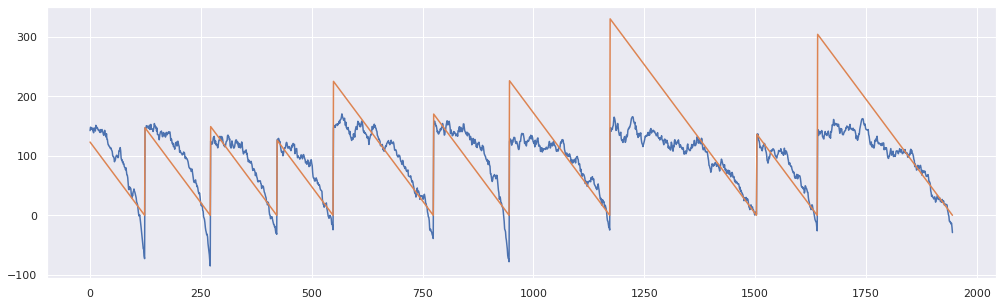

In [13]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(regressor.predict(val_dataset))
ax.plot(regressor.features_transformer.true_values(val_dataset))

### Test dataset results

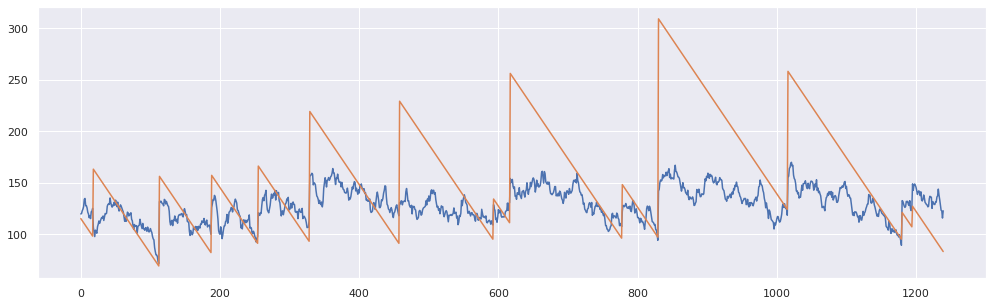

In [14]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(regressor.predict(test_dataset))
ax.plot(regressor.features_transformer.true_values(test_dataset))

## Parameters grid search


In [14]:
regressor.get_params()

{'memory': None,
 'steps': [('timeserieswindowtransformer',
   TimeSeriesWindowTransformer(transformer=<ceruleo.transformation.functional.transformers.Transformer object at 0x7fbcf559f070>,
                               window_size=16)),
  ('estimatorwrapper', EstimatorWrapper(estimator=Ridge(alpha=15)))],
 'verbose': False,
 'timeserieswindowtransformer': TimeSeriesWindowTransformer(transformer=<ceruleo.transformation.functional.transformers.Transformer object at 0x7fbcf559f070>,
                             window_size=16),
 'estimatorwrapper': EstimatorWrapper(estimator=Ridge(alpha=15)),
 'timeserieswindowtransformer__output_size': 1,
 'timeserieswindowtransformer__right_closed': True,
 'timeserieswindowtransformer__sample_weight': <ceruleo.iterators.sample_weight.NotWeighted at 0x7fbced5b4a90>,
 'timeserieswindowtransformer__shuffler': <ceruleo.iterators.shufflers.NotShuffled at 0x7fbced5b4a60>,
 'timeserieswindowtransformer__step': 1,
 'timeserieswindowtransformer__transformer': 

In [15]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=regressor,
             param_grid={
                 'timeserieswindowtransformer__window_size': [20, 40, 80, 160], 
            }
)
grid_search.fit(dataset)

NameError: name 'dataset' is not defined

## Tensorflow // Keras

### Build tf.Data iterators

In [15]:
from ceruleo.iterators.utils import true_values
from ceruleo.iterators.shufflers import AllShuffled
from ceruleo.iterators.iterators import WindowedDatasetIterator
from ceruleo.models.keras.dataset import tf_regression_dataset
import tensorflow as tf

#### Fit the transformer

In [17]:
transformer.fit(train_dataset)

#### Build the WindowedDatasetIterator

In [16]:
train_iterator = WindowedDatasetIterator(
    train_dataset.map(transformer),
    window_size=32,
    step=1,
    horizon=1,
    shuffler=AllShuffled())

val_iterator = WindowedDatasetIterator(
    val_dataset.map(transformer),
    window_size=32,
    step=1,
    horizon=1)

test_iterator = WindowedDatasetIterator(
    test_dataset.map(transformer),
    window_size=32,
    step=1,
    horizon=1)

### Build tensorflow model

In [26]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Conv1D, 
                                     SeparableConv1D, 
                                     GlobalMaxPooling1D,
                                     SpatialDropout1D,
                                     LayerNormalization,
                                     Dropout,
                                     Flatten, Dense, Lambda)

input = Input(train_iterator.shape)
x = Conv1D(64, 3, padding='same', activation='relu')(input)
x = Conv1D(64, 3, padding='same', activation='relu')(x)
x = Conv1D(64, 3, padding='same', activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model(input, x)
model.compile(loss='mae', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              weighted_metrics=[])

In [27]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 14)]          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 32, 64)            2752      
                                                                 
 conv1d_7 (Conv1D)           (None, 32, 64)            12352     
                                                                 
 conv1d_8 (Conv1D)           (None, 32, 64)            12352     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                           

In [28]:

model.fit(tf_regression_dataset(train_iterator).batch(32),
         validation_data=tf_regression_dataset(val_iterator).batch(32),
         epochs=25)

Epoch 1/25
488/488 [==============================] - 7s 14ms/step - loss: 63.1144 - val_loss: 43.9152
Epoch 2/25
488/488 [==============================] - 7s 14ms/step - loss: 32.0114 - val_loss: 43.1075
Epoch 3/25
488/488 [==============================] - 7s 15ms/step - loss: 30.6733 - val_loss: 43.3958
Epoch 4/25
488/488 [==============================] - 9s 19ms/step - loss: 29.7177 - val_loss: 42.2389
Epoch 5/25
488/488 [==============================] - 10s 21ms/step - loss: 28.5038 - val_loss: 42.3103
Epoch 6/25
488/488 [==============================] - 10s 21ms/step - loss: 27.4781 - val_loss: 40.7265
Epoch 7/25
488/488 [==============================] - 8s 17ms/step - loss: 26.7681 - val_loss: 41.0623
Epoch 8/25
488/488 [==============================] - 8s 16ms/step - loss: 25.9235 - val_loss: 43.9351
Epoch 9/25
488/488 [==============================] - 10s 20ms/step - loss: 25.7294 - val_loss: 41.6751
Epoch 10/25
488/488 [==============================] - 11s 23ms/step -

#### Validation set results

61/61 [==============================] - 1s 10ms/step


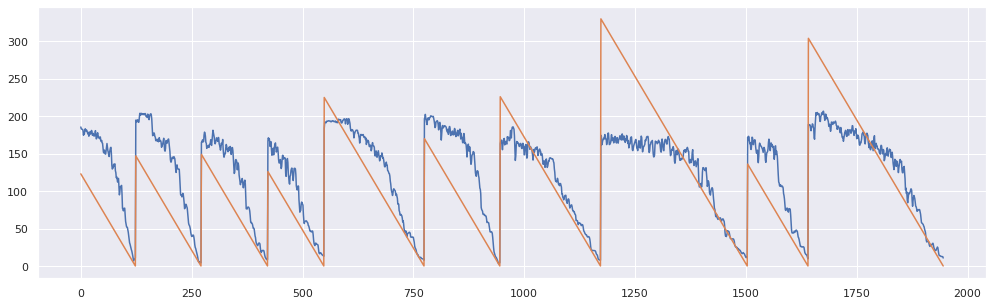

In [29]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(model.predict(tf_regression_dataset(val_iterator).batch(32)))
ax.plot(true_values(val_iterator))

#### Test set results

39/39 [==============================] - 0s 11ms/step


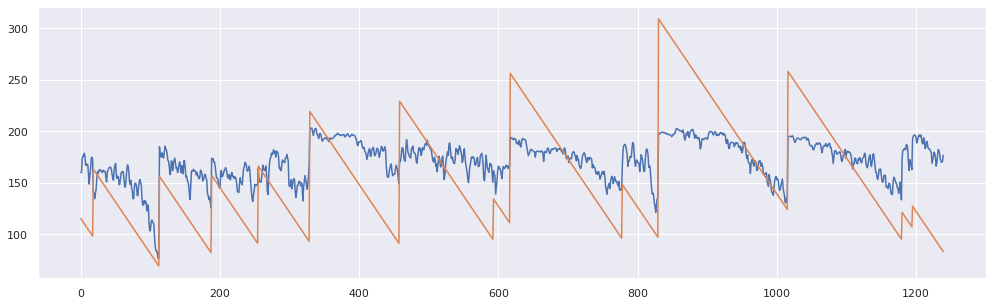

In [30]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(model.predict(tf_regression_dataset(test_iterator).batch(32)))
ax.plot(true_values(test_iterator))

### Catalog

In [41]:
from ceruleo.models.keras.models.MSWRLRCN import MSWRLRCN

model = MSWRLRCN(train_iterator.shape)
model.compile(loss='mae', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              weighted_metrics=[])
model.fit(tf_regression_dataset(train_iterator).batch(32),
         validation_data=tf_regression_dataset(val_iterator).batch(32),
         epochs=25)

(None, 3, 14)
Epoch 1/25
537/537 [==============================] - 43s 67ms/step - loss: 98.6610 - val_loss: 98.8013
Epoch 2/25
537/537 [==============================] - 42s 79ms/step - loss: 85.9146 - val_loss: 85.9673
Epoch 3/25
537/537 [==============================] - 39s 73ms/step - loss: 74.3280 - val_loss: 74.9894
Epoch 4/25
537/537 [==============================] - 42s 77ms/step - loss: 64.9662 - val_loss: 66.4363
Epoch 5/25
537/537 [==============================] - 43s 80ms/step - loss: 58.5549 - val_loss: 60.8506
Epoch 6/25
537/537 [==============================] - 43s 81ms/step - loss: 43.3630 - val_loss: 41.0580
Epoch 7/25
537/537 [==============================] - 42s 79ms/step - loss: 33.8808 - val_loss: 33.6760
Epoch 8/25
537/537 [==============================] - 47s 88ms/step - loss: 29.3030 - val_loss: 30.8910
Epoch 9/25
537/537 [==============================] - 50s 93ms/step - loss: 27.3868 - val_loss: 28.9876
Epoch 10/25
537/537 [=============================

KeyboardInterrupt: 

65/65 [==============================] - 4s 32ms/step


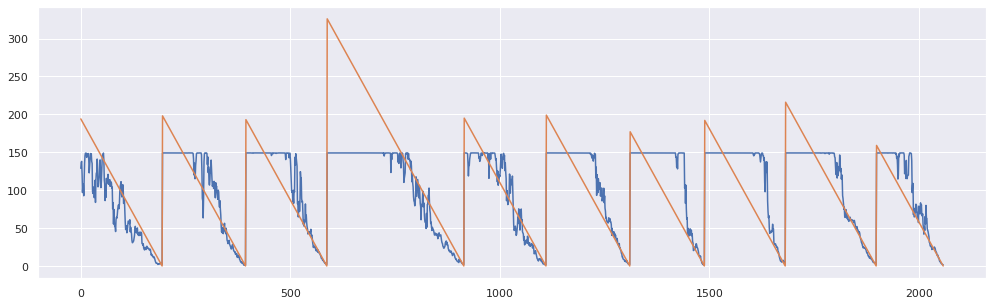

In [42]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(model.predict(tf_regression_dataset(val_iterator).batch(32)))
ax.plot(true_values(val_iterator))

47/47 [==============================] - 2s 34ms/step


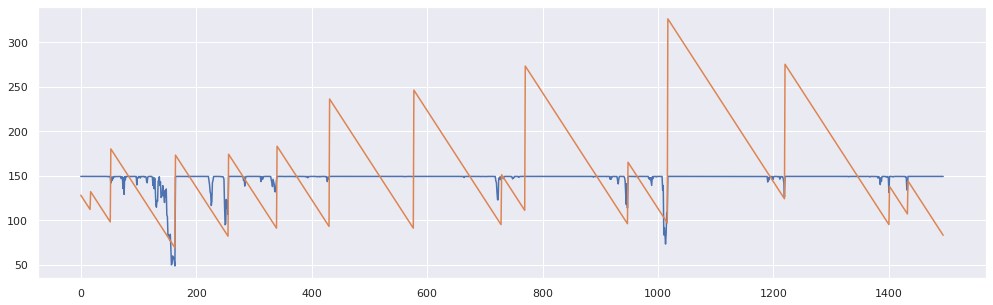

In [43]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(model.predict(tf_regression_dataset(test_iterator).batch(32)))
ax.plot(true_values(test_iterator))

## Pytorch